In [7]:
import SimpleITK as sitk
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.transform import resize
from skimage import io
from sklearn.utils import shuffle

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow as tf

Using TensorFlow backend.


In [14]:
def find_images(path_dir, path_nor, path_t):
    num=1
    X_train=np.zeros(((274+109)*num+942,240,240),dtype=np.uint16)
    Y_train=np.zeros(((274+109)*num+942,2),dtype=np.uint16)
    j=0
    for item in os.listdir(path_dir):
        item=os.path.join(path_dir,item)
        for item2 in os.listdir(item):
            im ={'T1':None,'gt':None}
            item2=os.path.join(item,item2)
            for item3 in os.listdir(item2):
                item3=os.path.join(item2,item3)
                for item4 in os.listdir(item3):
                    item5=os.path.join(item3,item4)
                    if os.path.isfile(item5) and item5.endswith('.mha'):
                        itk_image = sitk.ReadImage(item5)
                        nd_image = sitk.GetArrayFromImage(itk_image)
                        if 'more' in item5 or 'OT' in item5:
                            im['gt']=nd_image
                        elif 'T1' in item5 and 'T1c' not in item5:
                            im['T1']=nd_image
            for i in range(70,70+num):
                if not sum(sum(im['gt'][i,:,:])): #sum=0 normal brains
                    Y_train[j][0]=1
                else:
                    Y_train[j][1]=1
                X_train[j]=im['T1'][i,:,:]
                j+=1
    for item in os.listdir(path_nor):
        item2 = os.path.join(path_nor,item)
        img = nib.load(item2)
        data=img.get_fdata()
        for i in range(90,90+num):
            Y_train[j][0]=1
            X_train[j]=resize(data[50:210,i,:],(240,240))
            j+=1
    for item in os.listdir(path_t):
        item2=os.path.join(path_t,item)
        for item3 in os.listdir(item2):
            item5=os.path.join(item2,item3)
            if os.path.isfile(item5) and item5.endswith('.jpg'):
                image = io.imread(item5,as_gray=True)
                image = resize(image,(240,240))
                X_train[j]=image
                if item == 'abnormalsJPG':
                    Y_train[j][1]=1
                elif item == 'normalsJPG':
                    Y_train[j][0]=1
                j+=1
    return X_train,Y_train

In [11]:
path_dir="/media/pushpendra/DATA/4th sem/AML/assignment1/BRATS2015_Training"
path_nor="/media/pushpendra/DATA/4th sem/AML/assignment1/nii"
path_t="/media/pushpendra/DATA/4th sem/AML/assignment1/test_set"
X_train,Y_train=find_images(path_dir, path_nor, path_t)

/home/pushpendra/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [15]:
shape=X_train.shape
X_train=X_train.reshape(shape[0],shape[1],shape[2],1)
X_train.shape

In [8]:
path_t="/media/pushpendra/DATA/4th sem/AML/assignment1/normalsVsAbnormalsV1"
X_train,Y_train=find_test_images(path_t,842)
shape=X_train.shape
maxi = np.amax(X_train)
X_train = X_train/maxi
X_train=X_train.reshape(shape[0],shape[1],shape[2],1)
X_train.shape

abnormalsJPG
362
0
normalsJPG
362
480


(842, 240, 240, 1)

In [17]:
np.random.seed(1000)
model=Sequential()

model.add(Conv2D(filters=96, input_shape=(240,240,1), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256,kernel_size=(11,11),strides=(1,1),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))
model.add(BatchNormalization())

model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='valid'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding='valid'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(2))
model.add(Activation(tf.nn.softmax))

model.summary()

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 58, 58, 96)        11712     
_________________________________________________________________
activation_9 (Activation)    (None, 58, 58, 96)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 29, 96)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 29, 29, 96)        384       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 19, 19, 256)       2973952   
_________________________________________________________________
activation_10 (Activation)   (None, 19, 19, 256)       0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 256)         0         
__________

In [9]:
# from pdb import set_trace as trace
# trace()
X_train, Y_train = shuffle(X_train, Y_train)
model_checkpoint = ModelCheckpoint('Alexnet_brat.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(X_train,Y_train,batch_size=32,epochs=50,verbose=1,validation_split=0.2,shuffle=True, callbacks=[model_checkpoint])

Train on 673 samples, validate on 169 samples
Epoch 1/50
673/673 [==============================] - 93s 138ms/step - loss: 2.5452 - acc: 0.7935 - val_loss: 3.8225 - val_acc: 0.7219

Epoch 00001: loss improved from inf to 2.54516, saving model to Alexnet_brat.hdf5
Epoch 2/50
673/673 [==============================] - 84s 125ms/step - loss: 0.7464 - acc: 0.8410 - val_loss: 1.6696 - val_acc: 0.7929

Epoch 00002: loss improved from 2.54516 to 0.74640, saving model to Alexnet_brat.hdf5
Epoch 3/50
673/673 [==============================] - 81s 121ms/step - loss: 0.3556 - acc: 0.8856 - val_loss: 1.0293 - val_acc: 0.8166

Epoch 00003: loss improved from 0.74640 to 0.35560, saving model to Alexnet_brat.hdf5
Epoch 4/50
673/673 [==============================] - 85s 126ms/step - loss: 0.2074 - acc: 0.9346 - val_loss: 2.0647 - val_acc: 0.8225

Epoch 00004: loss improved from 0.35560 to 0.20741, saving model to Alexnet_brat.hdf5
Epoch 5/50
673/673 [==============================] - 82s 122ms/step -

KeyboardInterrupt: 

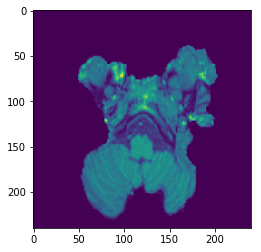

In [41]:
plt.imshow(X_train[340])

In [14]:
Y_train[13699]

array([1, 0], dtype=uint16)

In [3]:
from PIL import Image
def find_test_images(path_dir,num):
    X_test=np.zeros((num,240,240),dtype=np.uint16)
    Y_test=np.zeros((num,2),dtype=np.uint16)
    j=0
    k=0
    l=0
    for item in os.listdir(path_dir):
        item2=os.path.join(path_dir,item)
        for item3 in os.listdir(item2):
            item5=os.path.join(item2,item3)
            if os.path.isfile(item5) and item5.endswith('.jpg'):
                image = Image.open(item5).convert('L')
                image = image.resize((240,240),Image.ANTIALIAS)
                X_test[j]=image
                if item == 'abnormalsJPG':
                    Y_test[j][1]=1
                    k+=1
                elif item == 'normalsJPG':
                    Y_test[j][0]=1
                    l+=1
                j+=1
        print(item)
        print(k)
        print(l)
    return X_test,Y_test

In [52]:
test_path="/media/pushpendra/DATA/4th sem/AML/assignment1/normalsVsAbnormalsV2"
X_test,Y_test = find_test_images(test_path,942)

abnormalsJPG
412
0
normalsJPG
412
530


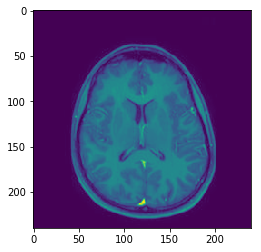

In [47]:
plt.imshow(X1_test[2].reshape(240,240))

In [53]:
X1_test=X_test/maxi
shape=X1_test.shape
X1_test=X1_test.reshape(shape[0],shape[1],shape[2],1)

In [63]:
model.load_weights("Alexnet_brat.hdf5")
results = model.predict(X1_test,verbose=1)

942/942 [==============================] - 33s 35ms/step


In [26]:
shape=X_test.shape
X_test=X_test.reshape(shape[0],shape[1],shape[2],1)

In [64]:
score, acc = model.evaluate(X1_test, Y_test,
                            batch_size=32)

942/942 [==============================] - 32s 34ms/step


In [65]:
score, acc

(5.219267451220178, 0.43736730360934184)

In [56]:
score, acc

(1.9171578449052769, 0.5626326963906582)

In [25]:
score, acc

(7.0757246872137305, 0.43630573248407645)

In [54]:
score, acc

(7.5278216987658455, 0.5169851381307954)

In [51]:
score,acc

(7.275505075788802, 0.5477707006369427)

In [82]:
score,acc

(1.2922971810504889, 0.564755838641189)

In [41]:
score, acc

(4.203026542663574, 0.64)

In [58]:
results = model.predict(X1_test,verbose=1)

942/942 [==============================] - 32s 34ms/step


In [42]:
results

array([[9.99997973e-01, 1.97380427e-06],
       [9.99984384e-01, 1.56149745e-05],
       [9.97331500e-01, 2.66849063e-03],
       [1.00000000e+00, 3.82436582e-11],
       [9.99999046e-01, 9.06403613e-07],
       [9.91952002e-01, 8.04791693e-03],
       [9.99999762e-01, 2.46044209e-07],
       [1.00000000e+00, 3.58943879e-08],
       [9.57459688e-01, 4.25402895e-02],
       [9.99878407e-01, 1.21552890e-04],
       [9.99999762e-01, 2.70984401e-07],
       [9.73105788e-01, 2.68942025e-02],
       [9.99898314e-01, 1.01668025e-04],
       [9.99936461e-01, 6.35697652e-05],
       [1.00000000e+00, 1.80782100e-09],
       [9.99993563e-01, 6.41946008e-06],
       [9.99999404e-01, 6.44308329e-07],
       [1.00000000e+00, 1.76474002e-10],
       [9.99998212e-01, 1.84571604e-06],
       [2.69951727e-02, 9.73004758e-01],
       [9.98845696e-01, 1.15432509e-03],
       [9.99984741e-01, 1.52489547e-05],
       [9.99999762e-01, 2.36230136e-07],
       [9.99995112e-01, 4.89447848e-06],
       [1.000000

In [66]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
visualize(X_test[0], 0,Y_test,results)

'Precision: [0.43736730360934184, 0.43736730360934184]\nRecall: [0.43736730360934184, 0.43736730360934184]\nF1-score: [0.43736730360934184, 0.43736730360934184]\nDistribution: [942, 942]'

In [21]:
def visualize(im, tiles, actual_target, predicted_target):
    
    precision, recall, fscore, support = precision_recall_fscore_support(actual_target.reshape((-1,1)), np.round(predicted_target.reshape((-1,1)) + 0.3))
    t = ('Precision: ' + str(list(precision)) + '\n' + 'Recall: ' + str(list(recall)) + '\n' + 'F1-score: ' + str(list(fscore)) + '\n' + 'Distribution: ' + str(list(support)))
       
#     tiles = tiles[:,:,:,0]
#     actual_target = actual_target[:,:,:,0]
#     predicted_target = predicted_target[:,:,:,0]

#     r,c = np.shape(im)
#     actual_target_im = np.zeros(np.shape(im))
#     predicted_target_im = np.zeros(np.shape(im))

#     # stich sub-images back to original image
#     cnt = 0 
#     for i in range(0,r,img_h):
#         for j in range(0,c,img_w):
#             x = actual_target_im[i:i+img_h,j:j+img_h]
#             if(x.shape[0]==img_h and x.shape[1]==img_w):
#                 actual_target_im[i:i+img_h,j:j+img_w] = actual_target[cnt]
#                 predicted_target_im[i:i+img_h,j:j+img_w] =  predicted_target[cnt] #tiles[cnt] + 200*
#                 cnt+=1
    
#     plt.figure(1,(15,9))
#     plt.subplot(1, 4, 1)
#     plt.title("Image")
#     im = plt.imshow(im, cmap = "gray",aspect = "auto") # orientation='horizontal',fraction=0.046, pad=0.04
#     # plt.colorbar(im)
#     plt.axis('off')
#     plt.subplot(1, 4, 2)
#     plt.title("Ground Truth")
#     # RdYlGn, seismic, tab10, plasma
#     im = plt.imshow(actual_target_im, cmap = "magma",aspect = "auto",vmin=0, vmax=1)
#     # plt.colorbar(im)
#     plt.axis('off')
#     plt.subplot(1, 4, 3)
#     plt.title("Prediction")
#     ax = plt.imshow(predicted_target_im, cmap = "magma",aspect = "auto",vmin=0, vmax=1)
#     plt.colorbar(ax)
#     plt.axis('off')
#     plt.subplot(1, 4, 4)
#     plt.axis('off')
#     plt.text(0.5, 0.5, t, ha = 'center',va='top',wrap=True)
#     global epoch_frames
#     epoch_frames += 1
#     plt.suptitle('epoch: ' + str(epoch_frames))
#     plt.savefig(home + "/experiment10b/output/copy_epoch_frames/frame"+str(epoch_frames)+ '.png')
#     # plt.show(block=False)
#     plt.close()
    return t